## A RNN model to analyse climate data

RNN are a type of deep learning architecture suited to work with **longitudinal data**, e.g. time series data.

Time series data include many types of data, like:

- economic indicators (e.g. *quarterly GDP*, *monthly inflation*)
- patient health evolution metrics (e.g.*ECG data*)

Time series data include a fundamental **time component**, and are often used in **forecasting problems**.

Here we use maximum daily temepratures in Melbourne (Australia), over the period 1981 - 1990, as an example to train a recurrent neural network (RNN) model.


In [1]:
## import relevant libraries
import numpy as np
import datetime as dt
import pandas as pd
import pandas_datareader
from pandas_datareader import data

In [2]:
## getting the data
DATAURL = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-max-temperatures.csv'
df = pd.read_csv(DATAURL)
print("N. of row in dataframe: ",len(df))
df.head()

N. of row in dataframe:  3650


,Date,Temperature
0,1981-01-01,38.1
1,1981-01-02,32.4
2,1981-01-03,34.5
3,1981-01-04,20.7
4,1981-01-05,21.5


We will use Melbourne maximum daily temperature (`Temperature`) in a forecasting problem

First, we split data into train/test: we use the last year as test, and all remaining observations as training set.

In [3]:
temperature = df['Temperature']
n = len(temperature) - 365 # training set
print('The size of the training data is', n)

The size of the training data is 3285


Let's have a look at the distribution of the training and testing data:

<Axes: >

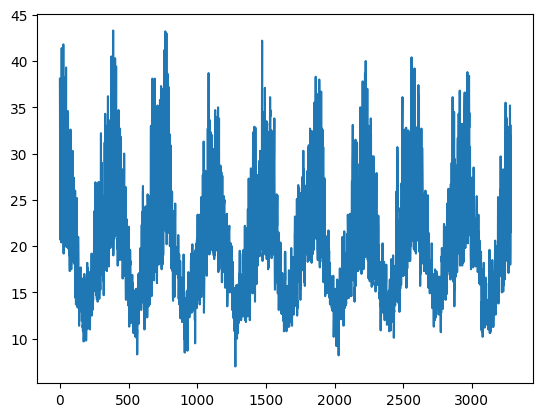

In [4]:
df['Temperature'][:n].plot()

<Axes: >

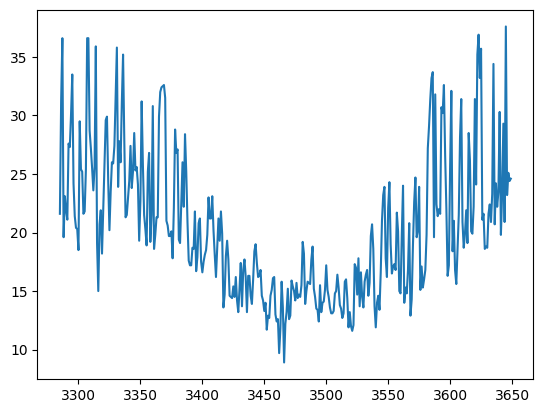

In [5]:
df['Temperature'][n:].plot()

In [6]:
train = list(temperature)[:n] #first n prices
test = list(temperature)[n:] #remaining prices

#### Data representation

We have two series of data (temperatures), for training and for testing.
For training, we have therefore one data series, and we need to use an appropriate representation for the feature data to be used for prediction (forecasting).

A common possibility is to use preceding values in the series to predict the next one(s): for instance, a sliding-window appraoch can be used (see figure below)

<img src="https://miro.medium.com/max/700/1*murkc0tNsvgdQDVgKqSdfQ.png">

In [7]:
## prepare the training data
windowSize, X_train, y_train = 10, [], [] #initialize lists and set window size
for index in range(len(train)-windowSize): #we must end at train-windowSize to avoid the windowSize going past the end
    X_train.append(train[index:index+windowSize]) #append the range from index to index+windowSize to x
    y_train.append(train[index+windowSize]) #append the next value to the y

X_train,y_train = np.array(X_train), np.array(y_train) #convert to numpy array
X_train = X_train.reshape((len(X_train), windowSize, 1)) #reshape X_train to proper 3-d array

print(y_train.shape)
print(X_train.shape)

(3275,)
(3275, 10, 1)


In [8]:
X_train[0,0:9,0]

array([38.1, 32.4, 34.5, 20.7, 21.5, 23.1, 29.7, 36.6, 36.1])

In [9]:
y_train[0]

20.4

In [10]:
## prepare the test data
windowSize, X_test, y_test = 10, [], [] #initialize lists and set window size
for index in range(len(test)-windowSize): #we must end at train-windowSize to avoid the windowSize going past the end
    X_test.append(test[index:index+windowSize]) #append the range from index to index+windowSize to x
    y_test.append(test[index+windowSize]) #append the next value to the y

X_test,y_test = np.array(X_test), np.array(y_test) #convert to numpy array
X_test = X_test.reshape((len(X_test), windowSize, 1)) #reshape X_train to proper 3-d array

print(y_test.shape)
print(X_test.shape)

(355,)
(355, 10, 1)


### Simple RNN

Let's start with a simple RNN model:
- one RNN layer (12 units)
- one dense layer (output layer: one number per timepoint, regression problem)

In [11]:
from keras import Sequential
from keras.layers import SimpleRNN, Dense

import math
import tensorflow as tf
import matplotlib.pyplot as plt

In [12]:
model = Sequential() #initializing sequential model, layers can be added sequentially with model.add
model.add(SimpleRNN(12, input_shape=(windowSize,1))) #simple recurrent layer, 10 neurons & process 10x1 sequences
model.add(Dense(1,activation='linear')) #linear output because this is a regression problem
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 12)                168       
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 181 (724.00 Byte)
Trainable params: 181 (724.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 12 units
- recurrent weights (states/activations are fed recursively): matrix $\mathbf{W_{aa}}(u,u)$
- input weights: n. units x n. features (here the number of features is 1: one sequence of previous values). For the blood pressure example, this would be 2 (diastolic and sistolic pressure values)
- one bias term per unit

$$
168 = 12 \text{ units} \cdot 12 \text{ units} + 12 \text{ units} \cdot 1 \text{ feature} + 12 \text{ bias terms}
$$

In [13]:
## let's fit the model
loss_function = 'mse'
optimizer_algorithm = 'Adam'
metrics_list = ['mae',tf.keras.metrics.RootMeanSquaredError()]
n_epochs = 20

model.compile(loss=loss_function, optimizer=optimizer_algorithm, metrics=metrics_list)
history = model.fit(X_train,y_train,epochs=n_epochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
103/103 [==============================] - 9s 13ms/step - loss: 423.6567 - mae: 19.6127 - root_mean_squared_error: 20.5829 - val_loss: 364.5612 - val_mae: 18.0482 - val_root_mean_squared_error: 19.0935
Epoch 2/20
103/103 [==============================] - 1s 10ms/step - loss: 307.3074 - mae: 16.3821 - root_mean_squared_error: 17.5302 - val_loss: 273.6912 - val_mae: 15.4243 - val_root_mean_squared_error: 16.5436
Epoch 3/20
103/103 [==============================] - 1s 10ms/step - loss: 249.4191 - mae: 14.5708 - root_mean_squared_error: 15.7930 - val_loss: 237.2922 - val_mae: 14.1994 - val_root_mean_squared_error: 15.4043
Epoch 4/20
103/103 [==============================] - 1s 10ms/step - loss: 216.2453 - mae: 13.3900 - root_mean_squared_error: 14.7053 - val_loss: 205.5117 - val_mae: 13.0267 - val_root_mean_squared_error: 14.3357
Epoch 5/20
103/103 [==============================] - 1s 10ms/step - loss: 186.7549 - mae: 12.2311 - root_mean_squared_error: 13.6658 - val_loss: 17

dict_keys(['loss', 'mae', 'root_mean_squared_error', 'val_loss', 'val_mae', 'val_root_mean_squared_error'])


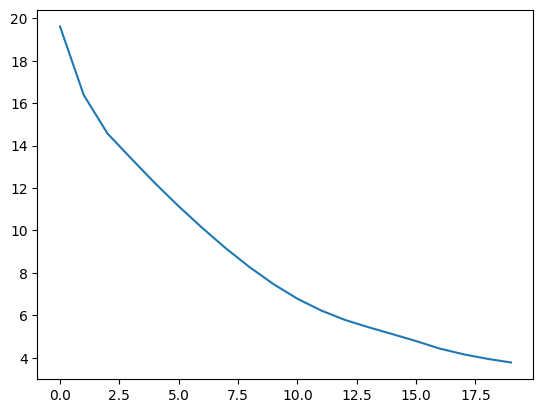

In [14]:
print(history.history.keys())
plt.plot(history.history['mae'])

In [15]:
## let's look at predictions
predictions = model.predict(X_test)
nrow = len(y_test)
temp = y_test.reshape(nrow,1)

## MAPE
ptc_err = 100*(abs(predictions - temp)/abs(temp))
mape = ptc_err.mean() # mean absolute percentage error

## RMSE
sqerr = (predictions - y_test)**2
rmse = math.sqrt(sqerr.mean())

print("accuracy (measured as MAPE) is: ", round(mape,2), " %")
print("accuracy (measured as RMSE) is: ", round(rmse,2), " degrees")

12/12 [==============================] - 0s 3ms/step
accuracy (measured as MAPE) is:  16.52  %
accuracy (measured as RMSE) is:  6.7  degrees


     index  y_test     y_pred
0        0    33.5  19.093920
1        1    24.2  19.094486
2        2    21.4  19.087038
3        3    20.4  19.058887
4        4    20.3  19.027632
..     ...     ...        ...
350    350    37.6  19.046072
351    351    23.2  19.094776
352    352    25.1  19.081909
353    353    24.4  19.089657
354    354    24.6  19.087738

[355 rows x 3 columns]


<Axes: >

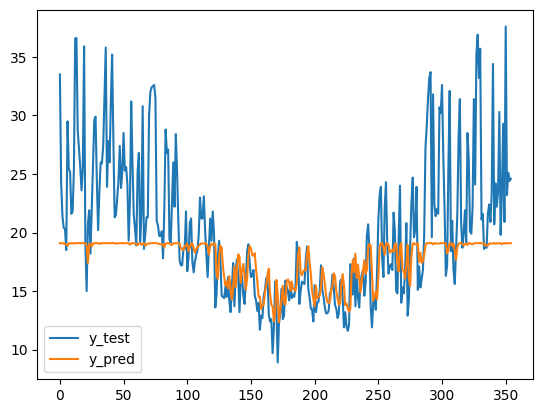

In [16]:
y_pred = pd.Series(predictions[:,0])
y = pd.Series(y_test.astype(float))

res = pd.DataFrame(dict(y_test = y, y_pred = y_pred)).reset_index()
print(res)
res[['y_test','y_pred']].plot()

Why is it so? We see that predictions fail to capture the highest temperatures at both extremes (left and right, australian summer).

**QUESTION: what is going on?**

### Data preprocessing

We may want to consider to normalise the data, that now are on the celsius degree scale.

First, we calculate the average and the standard deviation on the training data:

In [17]:
avg = df['Temperature'][:n].mean()
dev_std = df['Temperature'][:n].std()

Now, we can normalize (standardize) the data (both training and test):

In [18]:
train = (train-avg)/dev_std
test = (test-avg)/dev_std

In [19]:
train

array([2.96430023, 2.0322335 , 2.37562651, ..., 1.95047326, 0.24986029,
       2.13034579])

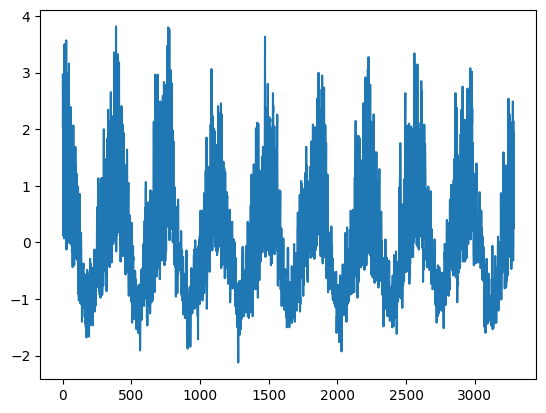

In [20]:
plt.plot(train)

Now we need to recreate the sliding-window representation (again, both for the training and the test data):

In [ ]:
## prepare the training data
windowSize, X_train, y_train = 10, [], [] #initialize lists and set window size
for index in range(len(train)-windowSize): #we must end at train-windowSize to avoid the windowSize going past the end
    X_train.append(train[index:index+windowSize]) #append the range from index to index+windowSize to x
    y_train.append(train[index+windowSize]) #append the next value to the y

X_train,y_train = np.array(X_train), np.array(y_train) #convert to numpy array
X_train = X_train.reshape((len(X_train), windowSize, 1)) #reshape X_train to proper 3-d array

print(y_train.shape)
print(X_train.shape)

In [ ]:
## prepare the test data
windowSize, X_test, y_test = 10, [], [] #initialize lists and set window size
for index in range(len(test)-windowSize): #we must end at train-windowSize to avoid the windowSize going past the end
    X_test.append(test[index:index+windowSize]) #append the range from index to index+windowSize to x
    y_test.append(test[index+windowSize]) #append the next value to the y

X_test,y_test = np.array(X_test), np.array(y_test) #convert to numpy array
X_test = X_test.reshape((len(X_test), windowSize, 1)) #reshape X_train to proper 3-d array

print(y_test.shape)
print(X_test.shape)

Let's fit again the RNN model:

In [ ]:
model = Sequential() #initializing sequential model, layers can be added sequentially with model.add
model.add(SimpleRNN(12, input_shape=(windowSize,1))) #simple recurrent layer, 10 neurons & process 10x1 sequences
model.add(Dense(1,activation='linear')) #linear output because this is a regression problem
model.summary()

In [ ]:
## let's fit the model
loss_function = 'mse'
optimizer_algorithm = 'Adam'
metrics_list = ['mae',tf.keras.metrics.RootMeanSquaredError()]
n_epochs = 20

model.compile(loss=loss_function, optimizer=optimizer_algorithm, metrics=metrics_list)
history = model.fit(X_train,y_train,epochs=n_epochs, verbose=1, validation_data=(X_test, y_test))

In [ ]:
plt.plot(history.history['mae'])

And now, the predictions: first, on the standardized scale

In [ ]:
## let's look at predictions
predictions = model.predict(X_test)
nrow = len(y_test)
temp = y_test.reshape(nrow,1)

## MAPE
ptc_err = 100*(abs(predictions - temp)/abs(temp))
mape = ptc_err.mean() # mean absolute percentage error

## RMSE
sqerr = (predictions - y_test)**2
rmse = math.sqrt(sqerr.mean())

print("accuracy (measured as MAPE) is: ", round(mape,2), " %")
print("accuracy (measured as RMSE) is: ", round(rmse,2), " dev std")

We see that the shape of the test data is now better captured:

In [ ]:
y_pred = pd.Series(predictions[:,0])
y = pd.Series(y_test.astype(float))

df = pd.DataFrame(dict(y_test = y, y_pred = y_pred)).reset_index()
print(df)
df[['y_test','y_pred']].plot()

#### Backtransform the data

Let's put our data back on the Celsius degrees scale:

$$
x_{degrees} = \sigma \cdot x_{std} + μ
$$

In [ ]:
y_pred = pd.Series(predictions[:,0])
y_pred = (y_pred * dev_std) + avg
y = pd.Series(y_test.astype(float))
y = (y * dev_std) + avg

df = pd.DataFrame(dict(y_test = y, y_pred = y_pred)).reset_index()
print(df)
df[['y_test','y_pred']].plot()

In [ ]:
## MAPE
ptc_err = 100*(abs(y_pred - y)/abs(y))
mape = ptc_err.mean() # mean absolute percentage error

## RMSE
sqerr = (y_pred - y)**2
rmse = math.sqrt(sqerr.mean())

print("accuracy (measured as MAPE) is: ", round(mape,2), " %")
print("accuracy (measured as RMSE) is: ", round(rmse,2), " degrees")

---
# END OF LIGHT DEMO PART - from now on: hic sunt leones!
---

### More RNN layers

Let's now make our neural network model more complex by adding layers (going "deep").

First, a sanity check on the input data:

In [ ]:
print(y_train[0:9])
print(X_train[0:4,0:4])
print(X_test[1:5,1:5])
print(y_test[1:10])

Now we build, compile and fit the model

In [ ]:
model = Sequential() #initialize model
model.add(SimpleRNN(32, input_shape=(windowSize,1), return_sequences=True)) #recurrent layer 1, 64 neurons
model.add(SimpleRNN(16, return_sequences=True)) #recurrent layer 2, 32 neurons
model.add(SimpleRNN(8)) #recurrent layer 3, 16 neurons
model.add(Dense(1,activation='linear')) #output dense layer (1 neuron) w/ linear activation
model.summary()

In [ ]:
loss_function = 'mse'
optimizer_algorithm = 'Adam'
metrics_list = ['mae',tf.keras.metrics.RootMeanSquaredError()]
n_epochs = 20

model.compile(loss=loss_function, optimizer=optimizer_algorithm, metrics=metrics_list)
history = model.fit(X_train,y_train,epochs=n_epochs, verbose=0, validation_data=(X_test, y_test))

In [ ]:
plt.plot(history.history['mae'])

In [ ]:
predictions = model.predict(X_test)

y_pred = pd.Series(predictions[:,0])
y_pred = (y_pred * dev_std) + avg
y = pd.Series(y_test.astype(float))
y = (y * dev_std) + avg

df = pd.DataFrame(dict(y_test = y, y_pred = y_pred)).reset_index()
print(df)
df[['y_test','y_pred']].plot()

In [ ]:
## MAPE
ptc_err = 100*(abs(y_pred - y)/abs(y))
mape = ptc_err.mean() # mean absolute percentage error

## RMSE
sqerr = (y_pred - y)**2
rmse = math.sqrt(sqerr.mean())

print("accuracy (measured as MAPE) is: ", round(mape,2), " %")
print("accuracy (measured as RMSE) is: ", round(rmse,2), " degrees")

## LSTM models

Let's now change the architecture of our RNN model, by using a specialized type of unit: the **long-short term memory** (LSTM) unit (see [here](https://keras.io/api/layers/recurrent_layers/lstm/))

In [ ]:
print(y_train[1:10])
print(X_train[1:5,1:5])
print(X_test[1:5,1:5])
print(y_test[1:10])

In [ ]:
from keras.layers import LSTM

model = Sequential() #initialize sequential model
model.add(LSTM(16, input_shape=(windowSize,1), return_sequences=True)) #LSTM layer with 10 neurons
# model.add(LSTM(16, return_sequences=True)) #LSTM layer with 10 neurons
model.add(LSTM(8)) #LSTM layer with 10 neurons
model.add(Dense(1,activation='linear')) #Dense output layer with 1 neuron, linear activation
model.summary()

In [ ]:
loss_function = 'mse'
optimizer_algorithm = 'Adam'
metrics_list = ['mae',tf.keras.metrics.RootMeanSquaredError()]
n_epochs = 20

model.compile(loss=loss_function, optimizer=optimizer_algorithm, metrics=metrics_list)
history = model.fit(X_train,y_train,epochs=n_epochs, verbose=0, validation_data=(X_test, y_test))

In [ ]:
plt.plot(history.history['mae'])

In [ ]:
predictions = model.predict(X_test)

y_pred = pd.Series(predictions[:,0])
y_pred = (y_pred * dev_std) + avg
y = pd.Series(y_test.astype(float))
y = (y * dev_std) + avg

df = pd.DataFrame(dict(y_test = y, y_pred = y_pred)).reset_index()
print(df)
df[['y_test','y_pred']].plot()

In [ ]:
## MAPE
ptc_err = 100*(abs(y_pred - y)/abs(y))
mape = ptc_err.mean() # mean absolute percentage error

## RMSE
sqerr = (y_pred - y)**2
rmse = math.sqrt(sqerr.mean())

print("accuracy (measured as MAPE) is: ", round(mape,2), " %")
print("accuracy (measured as RMSE) is: ", round(rmse,2), " degrees")

### More epochs?

In [ ]:
history = model.fit(X_train,y_train,epochs=200, verbose=0, validation_data=(X_test, y_test))

In [ ]:
plt.plot(history.history['mae'])

In [ ]:
predictions = model.predict(X_test)

y_pred = pd.Series(predictions[:,0])
y_pred = (y_pred * dev_std) + avg
y = pd.Series(y_test.astype(float))
y = (y * dev_std) + avg

df = pd.DataFrame(dict(y_test = y, y_pred = y_pred)).reset_index()
print(df)
df[['y_test','y_pred']].plot()

In [ ]:
## MAPE
ptc_err = 100*(abs(y_pred - y)/abs(y))
mape = ptc_err.mean() # mean absolute percentage error

## RMSE
sqerr = (y_pred - y)**2
rmse = math.sqrt(sqerr.mean())

print("accuracy (measured as MAPE) is: ", round(mape,2), " %")
print("accuracy (measured as RMSE) is: ", round(rmse,2), " degrees")

### Simple RNN, more epochs

In [ ]:
model = Sequential() #initializing sequential model, layers can be added sequentially with model.add
model.add(SimpleRNN(10, input_shape=(windowSize,1))) #simple recurrent layer, 10 neurons & process 50x1 sequences
model.add(Dense(1,activation='linear')) #linear output because this is a regression problem
model.summary()

In [ ]:
loss_function = 'mse'
optimizer_algorithm = 'Adam'
metrics_list = ['mae',tf.keras.metrics.RootMeanSquaredError()]
n_epochs = 200

model.compile(loss=loss_function, optimizer=optimizer_algorithm, metrics=metrics_list)
history = model.fit(X_train,y_train,epochs=n_epochs, verbose=0, validation_data=(X_test, y_test))

In [ ]:
predictions = model.predict(X_test)

y_pred = pd.Series(predictions[:,0])
y_pred = (y_pred * dev_std) + avg
y = pd.Series(y_test.astype(float))
y = (y * dev_std) + avg

df = pd.DataFrame(dict(y_test = y, y_pred = y_pred)).reset_index()
print(df)
df[['y_test','y_pred']].plot()

In [ ]:
## MAPE
ytt = df[['y_test']].values
ypp = df[['y_pred']].values
ptc_err = 100*(abs(ytt - ypp)/abs(ytt))
mape = ptc_err.mean() # mean absolute percentage error

## RMSE
sqerr = (ypp - ytt)**2
rmse = math.sqrt(sqerr.mean())

print("accuracy (measured as MAPE) is: ", round(mape,2), " %")
print("accuracy (measured as RMSE) is: ", round(rmse,2), " dollars")